#### Preparing Audio Files for CNN


For the cnn we want to input a the mel spectrograms of audio files, cropped to the first minute.

Spectrograms are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. It is calculated using the fast Fourier transform on short time windows of the signal and transforming the vertical axis (frequency) to log scale and the colored axis (amplitude) to decibals.

Now, what about the "mel" part? Humans are better at detecting differences in lower frequencies than higher frequencies. The mel scale transforms the frequency scale such that sounds at equal distances from each other also sound equal in distance. A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.


### Toy Example


In [1]:
import sys

sys.path.append("..")

In [2]:
import warnings
import pandas as pd
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from PIL import Image
import librosa
from tqdm import tqdm
from src.utils.audio_utils import find_chorus
from src.utils.plot_utils import plot_audio_wave, plot_mel_spectrogram
from src.utils.spectrograms import (
    save_spectrogram,
    get_mel_spectrogram,
    get_spectrograms,
)

warnings.filterwarnings("ignore")

In [3]:
AUDIO_DIR = "../data/track_downloads/"
CSV_PATH = "../data/audio_features.csv"
SPEC_DIR = "../data/spectrograms/"
SR = 22050

example_audio_path = AUDIO_DIR + "7ya7Jv4hJ9W0Baz7h9nL7E.wav"

### Extracting an Audio Signal

First we will load a demo track (Dance of the Sugar Plum Fairy by Tchaikovsky) and plot the waveform.

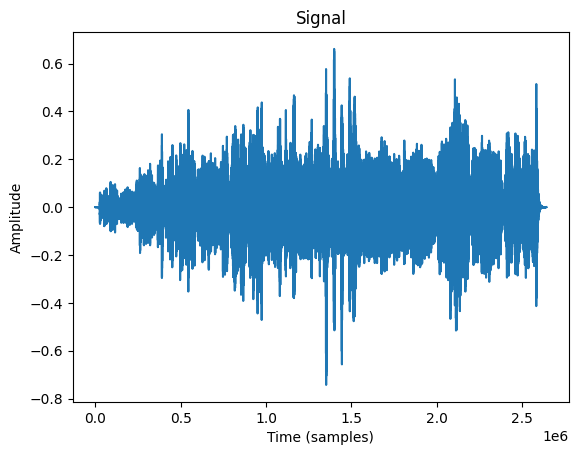

In [4]:
y, sr = librosa.load(librosa.ex('nutcracker'))
plot_audio_wave(y)

### Computing Spectrogram

Spectrograms are a way to visually represent a signal's loudness, or amplitude, as it varies over time at different frequencies. The horizontal axis is time, the vertical axis is frequency, and the color is amplitude. It is calculated using the fast Fourier transform on short time windows of the signal.

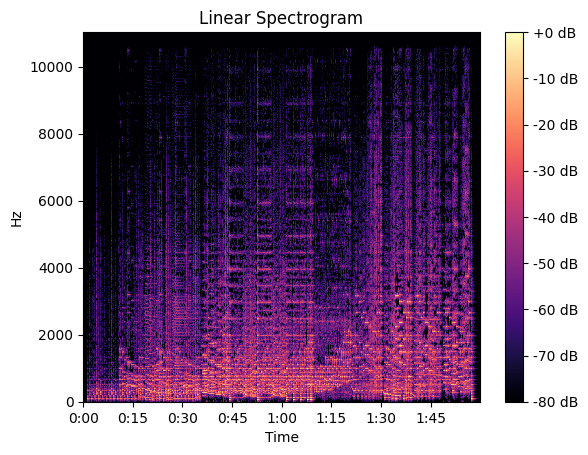

In [5]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Linear Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

### Mel Spectrograms

Humans are better at detecting differences in lower frequencies than higher frequencies. The mel scale transforms the frequency scale such that sounds at equal distances from each other also sound equal in distance. A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale.

This is what will be the input to the cnn!


Mel Spectrogram shape: (128, 5163)


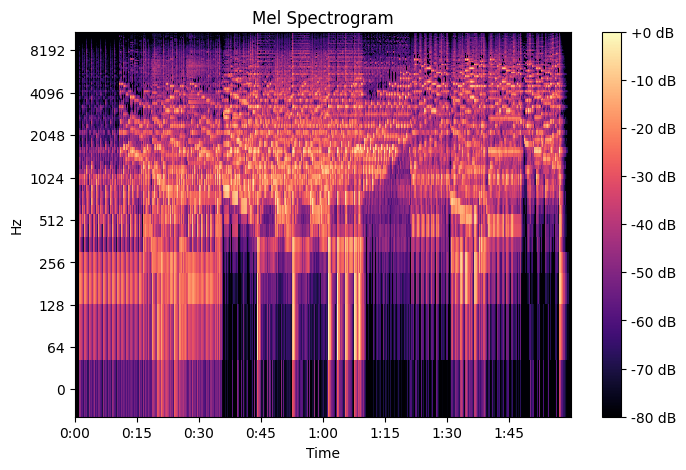

In [6]:
plot_mel_spectrogram(y, sr)

#### Downloading mel spectrogram as a png image


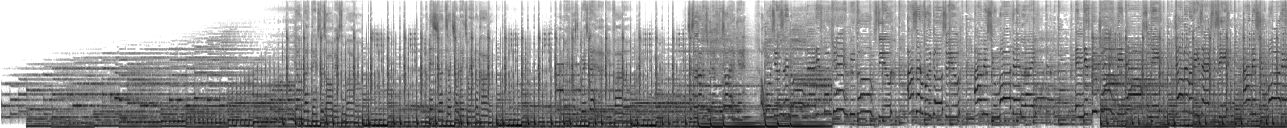

In [7]:
spec = get_mel_spectrogram(
    example_audio_path, offset=0, duration=60, hop_length=1024)
out_path = "../data/examples/mel_spectrogram.png"
save_spectrogram(spec, out_path)

# display image
img = Image.open(out_path)
display(img)

lower resolution (compressed)


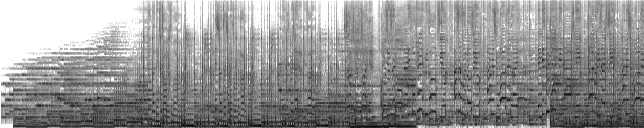

In [27]:
spec = get_mel_spectrogram(
    example_audio_path, offset=0, duration=60, hop_length=2048)
out_path = "../data/examples/mel_spectrogram_low.png"
save_spectrogram(spec, out_path)

# display image
img = Image.open(out_path)
display(img)

### Saving Many Mel Spectrograms as Images


Starting with the 500 most and least viral songs, across different combinations of settings


In [8]:
def many_spectrograms(top_or_bottom, res, duration, num_tracks, out_dir, chorus):
    # get length of csv
    df = pd.read_csv(CSV_PATH)
    num_tracks = len(df)
    start_index = 0 if top_or_bottom == "top" else num_tracks - 500
    end_index = 500 if top_or_bottom == "top" else num_tracks - 1

    get_spectrograms(
        AUDIO_DIR, CSV_PATH, out_dir, duration, start_index, end_index, res, chorus
    )

downloading spectrograms for all combinations


In [10]:
# num_tracks = 500
# for res in ["low", "high"]:
#     for duration in [60, 30]:
#         for virality in ["top", "bottom"]:
#             out_dir = f"../data/spectrograms/{res}_{duration}_{num_tracks}/{virality}/"
#             many_spectrograms(virality, res, duration, num_tracks, out_dir, chorus=False)

do the same thing but with the song chorus instead of the track beginning


Best chorus found at 1 min 4.27 sec


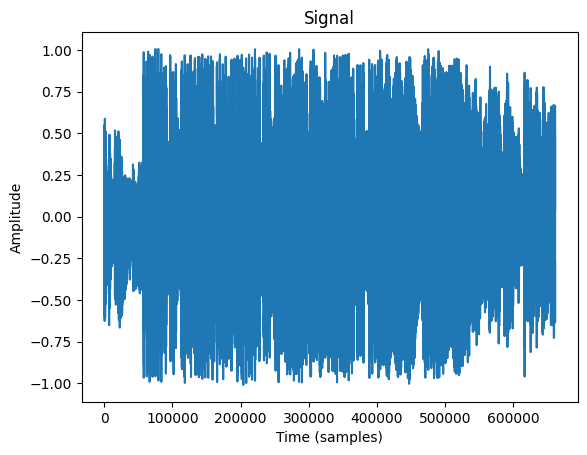

In [11]:
# example
chorus_start = find_chorus(example_audio_path, duration=30)
y, sr = librosa.load(
    example_audio_path, offset=chorus_start, sr=SR, mono=True, duration=30
)  # type: ignore

plot_audio_wave(y)

Mel Spectrogram shape: (128, 1292)


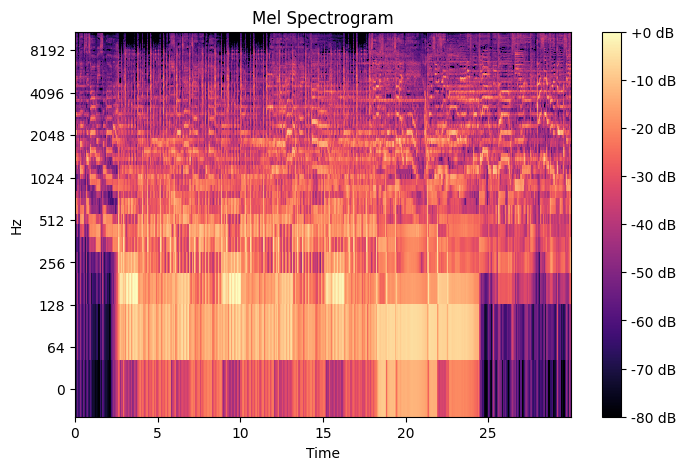

In [12]:
plot_mel_spectrogram(y, sr)

In [13]:
# num_tracks = 500
# for res in ["low", "high"]:
#     for duration in [15, 30]:
#         for virality in ["top", "bottom"]:
#             out_dir = f"../data/spectrograms/ch_{res}_{duration}_{num_tracks}/{virality}/"
#             many_spectrograms(virality, res, duration, num_tracks, out_dir, chorus=True)

### processing all of the tracks:


In [9]:
# change these params
res = "high"
duration = 15

out_dir = f"../data/spectrograms/ch_{res}_{duration}_all/"
get_spectrograms(
    AUDIO_DIR,
    CSV_PATH,
    out_dir,
    duration,
    start_index=0,
    end_index=0,
    res=res,
    chorus=True,
)

Processing track 0 of 3932
Best chorus found at 2 min 3.65 sec
Processing track 1 of 3932
Best chorus found at 1 min 7.02 sec
Processing track 2 of 3932
No choruses were detected. Try a smaller search duration
Processing track 3 of 3932
No choruses were detected. Try a smaller search duration
Processing track 4 of 3932
Best chorus found at 1 min 45.70 sec
Processing track 5 of 3932
No choruses were detected. Try a smaller search duration
Processing track 6 of 3932
Best chorus found at 1 min 18.56 sec
Processing track 7 of 3932
Best chorus found at 2 min 37.05 sec
Processing track 8 of 3932
Best chorus found at 2 min 15.14 sec
Processing track 9 of 3932
No choruses were detected. Try a smaller search duration
Processing track 10 of 3932
Best chorus found at 1 min 3.71 sec
Processing track 11 of 3932
Best chorus found at 1 min 10.57 sec
Processing track 12 of 3932
No choruses were detected. Try a smaller search duration
Processing track 13 of 3932
Best chorus found at 0 min 49.78 sec
Pro

[array([[-33.517883, -30.776314, -31.932577, ..., -28.09672 , -30.190321,
         -30.47748 ],
        [-24.905472, -22.419353, -24.76389 , ..., -21.500938, -26.990643,
         -15.414257],
        [-19.82038 , -20.701338, -18.717163, ..., -20.117767, -26.239883,
         -17.41793 ],
        ...,
        [-58.7144  , -51.713776, -51.64338 , ..., -52.275352, -49.982513,
         -52.218567],
        [-60.056786, -57.34453 , -55.397766, ..., -58.90236 , -54.662743,
         -56.218555],
        [-70.03195 , -68.58968 , -65.11623 , ..., -71.21452 , -65.529236,
         -64.703186]], dtype=float32),
 array([[-67.34117 , -57.944595, -55.32431 , ..., -20.92097 ,  -7.161375,
         -16.79549 ],
        [-61.454403, -57.15116 , -47.89537 , ..., -15.968189,  -4.473049,
         -15.000385],
        [-52.834557, -54.29235 , -37.629166, ..., -11.781076, -18.184124,
         -30.641193],
        ...,
        [-80.      , -80.      , -80.      , ..., -61.46712 , -80.      ,
         -80.      